In [13]:
import pandas as pd
import numpy as np

In [14]:
coso = pd.read_csv('data/coso.csv')
new0 = pd.read_csv('data/New_DB_new0.csv')
new0 = new0[['PP', 'slope', 'valor_humedad_suelo1', 'Latitud', 'Longitud']].dropna()
coso = coso[['PP', 'slope', 'valor_humedad_suelo1', 'Latitud', 'Longitud']].dropna()

data_0 = pd.read_csv('data/xterrae_data_0').dropna()
data_1 = pd.read_csv('data/xterrae_data_1').dropna()

data_0 = pd.merge(new0, data_0, on=['Latitud', 'Longitud'], how='inner')
data_1 = pd.merge(coso, data_1, on=['Latitud', 'Longitud'], how='inner')

data_0 = data_0.drop(columns=['Unnamed: 0', 'Latitud', 'Longitud'])
data_1 = data_1.drop(columns=['Unnamed: 0', 'Latitud', 'Longitud'])
data_0['Valor'] = 0
data_1['Valor'] = 1

final_db = pd.read_csv('data/final_db.csv')
final_db = final_db.drop(columns='Unnamed: 0')

In [15]:
#importe de funciones locales
from util import comparar_columnas, eliminar_caracteristicas, prueba_umbral

#Analizar si todas las columnas estan para luego concatenar
comparar_columnas(final_db, data_0)
comparar_columnas(final_db, data_1)

Todas las columnas de df1 están en df2.
Todas las columnas de df2 están en df1.
Todas las columnas de df1 están en df2.
Todas las columnas de df2 están en df1.


In [16]:
# Concatenación y eliminación de valores NaN
final = pd.concat([final_db, data_0])
final = pd.concat([final, data_1])
final = final.dropna()

# Separación de los valores
final_x = final.drop(columns='Valor')
final_y = final.Valor


In [17]:
# Prueba de características eliminadas a parti de diferentes valores de umbrales
umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
resultados = prueba_umbral(final, umbrales=umbrales)
print(resultados)

   Umbral  Caracteristicas eliminadas
0    0.10                         136
1    0.20                         135
2    0.30                         131
3    0.40                         130
4    0.50                         128
5    0.60                         128
6    0.70                         122
7    0.80                         113
8    0.90                          91
9    0.99                          38


In [18]:
# Se reduce el df según el valor de umbral elegido
df_reducido, num_eliminadas = eliminar_caracteristicas(final, 0.99)
final = df_reducido
print(f'Dimensión del df después de eliminación por umbral: {final.shape}')

Dimensión del df después de eliminación por umbral: (3148, 99)


In [19]:
# Importaciones de funciones para generar los modelos
# Importaciones de selección de características
from feature_selection import cart_feature_selection, seleccion_caracteristicas_genetico
from models_gen_X_y import xgboost_random_search, xgboost_bayesopt_classifier, mlp_binary_classification

In [20]:
# Selección de características por cart y luego se establecen los dataframe con las características elegidas
cart_features = cart_feature_selection(final, 'Valor', n_features=30)
X = final[cart_features]
y = final['Valor']
print(f'Caracateristicas seleccionadas por cart: {cart_features}')

Caracateristicas seleccionadas por cart: ['slope', 'valor_humedad_suelo1', 'PP', 'ksat_60-100cm.tif', 'PIRange_Clay.15-30cm.tif', 'PIRange_Bulkd.60-100cm.tif', 'PIRange_Clay.30-60cm.tif', 'PIRange_Clay.0-5cm.tif', 'PIRange_Clay.100-200cm.tif', 'PIRange_Clay.60-100cm.tif', 'Bulkd.60-100cm.tif', 'PIRange_Bulkd.5-15cm.tif', 'Clay.5-15cm.tif', 'Clay.15-30cm.tif', 'PIRange_Bulkd.100-200cm.tif', 'PIRange_Sand.15-30cm.tif', 'Clay.0-5cm.tif', 'Silt.15-30cm.tif', 'n_30-60cm.tif', 'PIRange_Sand.30-60cm.tif', 'n_5-15cm.tif', 'PIRange_Sand.60-100cm.tif', 'Bulkd.15-30cm.tif', 'PIRange_Sand.0-5cm.tif', 'ksat_100-200cm.tif', 'AvMoist.60-100cm.tif', 'ksat_5-15cm.tif', 'Sand.0-5cm.tif', 'n_60-100cm.tif', 'ksat.15-30cm.tif']


Número de muestras de entrenamiento: 2518, Número de muestras de prueba: 630
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión: 87.94%


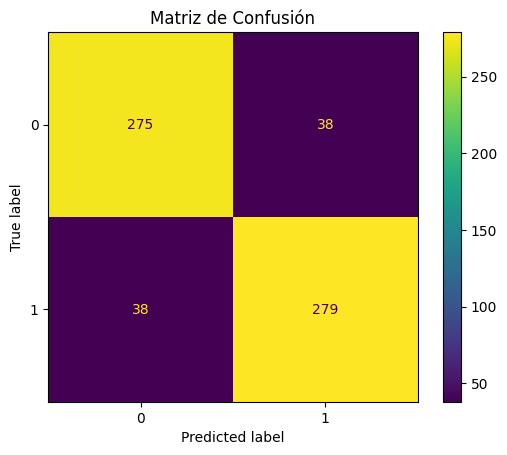

{'best_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=0.1, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=500,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 'accuracy': 0.8793650793650793,
 'best_params': {'subsample': 1.0,
  'reg_lambda': 0,
  'reg_alpha': 0.1,
  'n_estimators': 500,
  'max_depth': 5,
  'learning_rate': 0.1,
  'gamma': 0.1,
  'colsample_bytree': 1.0}}

In [21]:
# Estancia para modelo de xgboost_random_search

# Se define los parámetros a buscar para el ajuste del modelo
param_grid = {
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300, 500],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 1.0, 10.0]
        }
xgboost_random_search(X, y, param_grid=param_grid)

Informe de clasificación
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       306
           1       0.76      0.77      0.76       324

    accuracy                           0.75       630
   macro avg       0.75      0.75      0.75       630
weighted avg       0.75      0.75      0.75       630

Matriz de confusión
[[227  79]
 [ 76 248]]


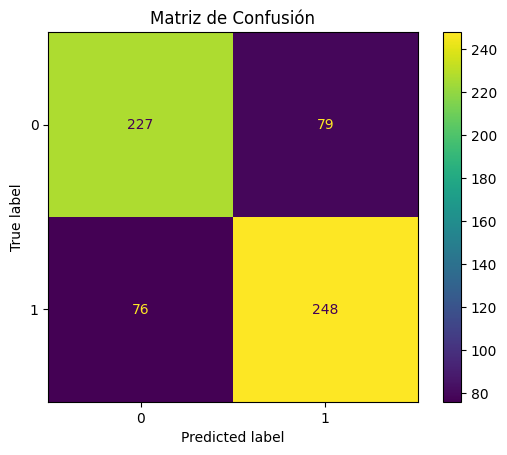

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,
                               random_state=42))])

In [22]:
mlp_binary_classification(X,y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\ivo\.conda\envs\geotiff\lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros encontrados:
{'xgb__colsample_bytree': 0.7954166302845054, 'xgb__gamma': 0.015250124969524714, 'xgb__learning_rate': 0.046974706861722275, 'xgb__max_depth': 8, 'xgb__min_child_weight': 3.381022389395617, 'xgb__n_estimators': 543, 'xgb__subsample': 0.6633256208980205}

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       306
           1       0.83      0.85      0.84       324

    accuracy                           0.83       630
   macro avg       0.83      0.83      0.83       630
weighted avg       0.83      0.83      0.83       630


Matriz de confusión:
[[249  57]
 [ 50 274]]


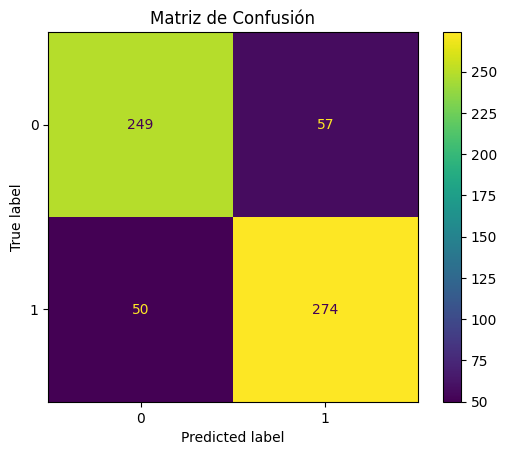

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importa...
                                        'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023E641EA370>,
                                        'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023E39889F10>,
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023E3989D070>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023E398C1A60>},
                   random_state=42, verbose=1)

In [23]:
xgboost_bayesopt_classifier(X,y)

In [24]:
# Se obtuvieron los valores de lo modelos con los datos raw
# ahora se realiza la depuración mediante PUBagging para reentrenar los model
# y comparar los resultados de los modelos sin/con PUBagging

from pubagging import PUBagging

data = final[cart_features]
data['Valor'] = final.Valor
data_aux_1 = data[data.Valor == 1]
data_aux_0 = data[data.Valor == 0]
data_aux_0 = data_aux_0.drop(columns='Valor')
data_aux_1 = data_aux_1.drop(columns='Valor')

landslide_samples = data_aux_1# Example landslide samples as DataFrame
unlabeled_samples = data_aux_0# Example unlabeled samples as DataFrame

pu_bagging = PUBagging(num_iterations=5, sample_ratio=0.4, random_state=42)

pu_bagging.fit(landslide_samples, unlabeled_samples)

probabilities = pu_bagging.predict_proba(unlabeled_samples)
print("Predicted probabilities:", probabilities)

threshold = 0.5 

# Filtrar muestras no deslizamiento por debajo del umbral
non_landslide_indices = np.where(probabilities < threshold)[0]
selected_non_landslide_samples = unlabeled_samples.iloc[non_landslide_indices]

# Ejemplo de cómo podrías utilizar las muestras seleccionadas
print("Muestras no deslizamiento seleccionadas:")
print(selected_non_landslide_samples)

# Se crean los nuevos dataframe para el reentreno donde tenemos data y data_y como input y output respectivamente
selected_non_landslide_samples['Valor'] = 0
data_aux_1['Valor'] = 1

data = pd.concat([data_aux_1, selected_non_landslide_samples])
data_y = data['Valor']
data = data.drop(columns=['Valor'])

C:\Users\ivo\AppData\Local\Temp\ipykernel_2232\2406970788.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Valor'] = final.Valor


Predicted probabilities: [0.2 0.  0.2 ... 0.2 0.2 0.6]
Muestras no deslizamiento seleccionadas:
          slope  valor_humedad_suelo1          PP  ksat_60-100cm.tif  \
0     32.357300              0.421875   13.532034         282.394012   
1     32.357300              0.438995  238.139918         282.394012   
2     37.497812              0.520004   32.059045         144.182007   
3     36.717389              0.478973    0.000000          90.413002   
4     60.517945              0.438095    2.191190         343.306000   
...         ...                   ...         ...                ...   
1162  24.327043              0.416611    0.674241         279.865997   
1163  24.327043              0.416611    0.674241         261.084015   
1164  24.641348              0.313675    1.054908         252.315994   
1166  35.755171              0.306458    0.000000         120.091003   
1167  40.502730              0.335510    0.000000         119.821999   

      PIRange_Clay.15-30cm.tif  PIRange

C:\Users\ivo\AppData\Local\Temp\ipykernel_2232\2406970788.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_non_landslide_samples['Valor'] = 0


Número de muestras de entrenamiento: 2356, Número de muestras de prueba: 589
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión: 86.08%


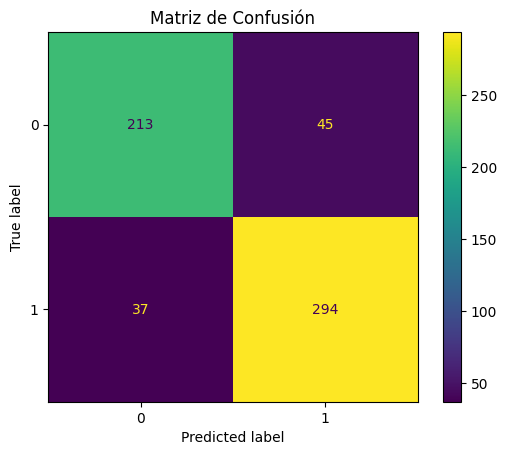

{'best_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=0, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.3, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=500,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 'accuracy': 0.8607809847198642,
 'best_params': {'subsample': 1.0,
  'reg_lambda': 1.0,
  'reg_alpha': 0.5,
  'n_estimators': 500,
  'max_depth': 7,
  'learning_rate': 0.3,
  'gamma': 0,
  'colsample_bytree': 0.8}}

In [25]:
# Se realiza el reentranmiento de los modelos con los datos ahora depurados
xgboost_random_search(data, data_y, param_grid=param_grid)